In [18]:
import numpy as np 
from scipy.linalg import orth
from FlagRep import FlagRep
from FlagRep0 import chordal_distance

In [19]:


# Parameters
n = 200              # dimension ambient space
signature = [2, 2]  # true flag signature
sum_sig = np.cumsum(signature)
st = sum(signature)

# Generate the central flag matrix (complex orthogonal)
Ftrue = orth(np.random.randn(n, st) + 1j * np.random.randn(n, st))  # Central flag

sigma = 0.5          # Gaussian noise variance perturbation
Nsamples = 10       # Number of samples on each set

# --- Low-resolution samples (low-dim subspace) --- #
Xlr = Ftrue[:, :signature[0]] @ (np.random.randn(signature[0], Nsamples) + 1j * np.random.randn(signature[0], Nsamples)) / np.sqrt(2)

# --- High-resolution samples (high-dim subspace) --- #
Xhr = Ftrue[:, :st] @ (np.random.randn(st, Nsamples) + 1j * np.random.randn(st, Nsamples)) / np.sqrt(2)
X = np.hstack((Xlr, Xhr))  # Whole dataset

# --- Noisy observations --- #
Zlr = Xlr + np.sqrt(sigma / 2) * (np.random.randn(*Xlr.shape) + 1j * np.random.randn(*Xlr.shape))
Zhr = Xhr + np.sqrt(sigma / 2) * (np.random.randn(*Xhr.shape) + 1j * np.random.randn(*Xhr.shape))


Z = np.hstack([Zlr, Zhr])

In [20]:
As = [np.arange(Zlr.shape[1]), np.arange(Zlr.shape[1]+Zhr.shape[1])]
my_fr = FlagRep(Aset = As, flag_type = list(sum_sig))

Xfr, Rfr = my_fr.fit_transform(Z)
XrecFlag = Xfr @ Rfr
print('nate')
print(np.linalg.norm(XrecFlag -X)**2/(2*Nsamples))

# --- Perform SVD on low-resolution noisy data (Zlr * Zlr') --- #
Ulr, Dlr, Vlr = np.linalg.svd(Z)  # SVD on Zlr * Zlr'
Ulr_flag = Ulr[:, :signature[0]]  # Extract first `signature[0]` columns
Plr_flag = Ulr_flag @ Ulr_flag.conj().T  # Projection matrix for low-resolution flag

# --- High-resolution component, removing low-resolution projection --- #
Bhr = (np.eye(n) - Plr_flag) @ Zhr  # Project Zhr orthogonal to Plr_flag

# --- Perform SVD on the high-resolution residual (Bhr * Bhr') --- #
Uhr, Dhr, Vhr = np.linalg.svd(Bhr)  # SVD on Bhr * Bhr'
Uhr_flag = Uhr[:, :signature[1]]  # Extract first `signature[1]` columns

# --- Combine flags for reconstruction --- #
Uflag = np.hstack((Ulr_flag, Uhr_flag))  # Concatenate the two flag subspaces
XrecFlag_nacho = (Uflag @ Uflag.conj().T) @ Z  # Reconstructed flag
print('nacho')
print(np.linalg.norm(XrecFlag_nacho -X)**2/(2*Nsamples))

U = np.linalg.svd(Z)[0][:,:4]
print('svd')
print(np.linalg.norm(U @ U.conj().T @ Z -X)**2/(2*Nsamples))

nate
27.824618488921043
nacho
28.66243790961215
svd
29.48854387605055


/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_67828/3213270919.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([pd.DataFrame(columns = results.columns, data = [['nate', nate_err, nate_cdist, noise_scale]]), results])


<Axes: xlabel='noise', ylabel='dist'>

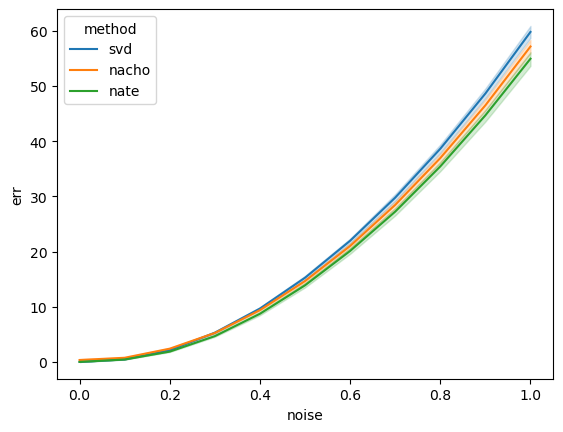

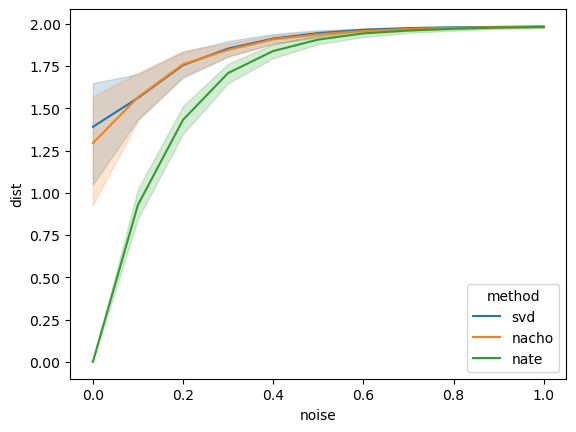

In [26]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Parameters
n = 200              # dimension ambient space
signature = [2, 2]  # true flag signature
sum_sig = np.cumsum(signature)
st = sum(signature)

Bs = [np.arange(sum_sig[0])]
for i in range(1,len(sum_sig)):
    Bs.append(np.arange(sum_sig[i-1],sum_sig[i]))



results = pd.DataFrame(columns = ['method', 'err', 'dist', 'noise'])

for noise_scale in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]:
    for sd in range(10):
        np.random.seed(sd)

        # Generate the central flag matrix (complex orthogonal)
        Ftrue = orth(np.random.randn(n, st) )  # Central flag

        Nsamples = 10       # Number of samples on each set

        # --- Low-resolution samples (low-dim subspace) --- #
        Xlr = Ftrue[:, :signature[0]] @ (np.random.normal(size = (signature[0], Nsamples)))

        # --- High-resolution samples (high-dim subspace) --- #
        Xhr = Ftrue[:, signature[0]:st] @ (np.random.normal(size = (signature[1], Nsamples)))
        X = np.hstack((Xlr, Xhr))  # Whole dataset

        # --- Noisy observations --- #
        Zlr = Xlr +  (np.random.normal(size = Xlr.shape, scale = noise_scale))
        Zhr = Xhr + (np.random.normal(size = Xhr.shape, scale = noise_scale))


        Z = np.hstack([Zlr, Zhr])

        As = [np.arange(Zlr.shape[1]), np.arange(Zlr.shape[1]+Zhr.shape[1])]
        my_fr = FlagRep(Aset = As, flag_type = list(sum_sig))

        Xfr, Rfr = my_fr.fit_transform(Z)
        XrecFlag = Xfr @ Rfr
        # print('nate')
        nate_err = np.sum(np.linalg.norm(XrecFlag -X,axis = 1)**2)/(2*Nsamples)
        nate_cdist = chordal_distance(Xfr, Ftrue, Bs, Bs)
        # print(nate)
        results = pd.concat([pd.DataFrame(columns = results.columns, data = [['nate', nate_err, nate_cdist, noise_scale]]), results])

        # --- Perform SVD on low-resolution noisy data (Zlr * Zlr') --- #
        Ulr, Dlr, Vlr = np.linalg.svd(Z)  # SVD on Zlr * Zlr'
        Ulr_flag = Ulr[:, :signature[0]]  # Extract first `signature[0]` columns
        Plr_flag = Ulr_flag @ Ulr_flag.conj().T  # Projection matrix for low-resolution flag

        # --- High-resolution component, removing low-resolution projection --- #
        Bhr = (np.eye(n) - Plr_flag) @ Zhr  # Project Zhr orthogonal to Plr_flag

        # --- Perform SVD on the high-resolution residual (Bhr * Bhr') --- #
        Uhr, Dhr, Vhr = np.linalg.svd(Bhr)  # SVD on Bhr * Bhr'
        Uhr_flag = Uhr[:, :signature[1]]  # Extract first `signature[1]` columns

        # --- Combine flags for reconstruction --- #
        Uflag = np.hstack((Ulr_flag, Uhr_flag))  # Concatenate the two flag subspaces
        XrecFlag_nacho = (Uflag @ Uflag.conj().T) @ Z  # Reconstructed flag
        # print('nacho')
        nacho_err = np.sum(np.linalg.norm(XrecFlag_nacho -X, axis = 1)**2)/(2*Nsamples)
        nacho_cdist = chordal_distance(Uflag, Ftrue, Bs, Bs)
        # print(nacho)
        results = pd.concat([pd.DataFrame(columns = results.columns, data = [['nacho',nacho_err, nacho_cdist, noise_scale]]), results])

        U = np.linalg.svd(Z)[0][:,:4]
        # print('svd')
        svd_err = np.sum(np.linalg.norm(U @ U.conj().T @ Z -X, axis = 1)**2)/(2*Nsamples)
        svd_cdist = chordal_distance(U, Ftrue, Bs, Bs)
        # print(svd)
        results = pd.concat([pd.DataFrame(columns = results.columns, data = [['svd', svd_err, svd_cdist, noise_scale]]), results])

plt.figure()
sns.lineplot(data = results, hue = 'method', y = 'err', x = 'noise')
# plt.yscale('log')

plt.figure()
sns.lineplot(data = results, hue = 'method', y = 'dist', x = 'noise')